In [1]:
import torch
from torch.autograd import Variable
dtype = torch.FloatTensor

In [2]:
import numpy as np
pi = np.pi

## Simultaneous search for policy and verifying Lyapunov function

$$\dot{x} = f(x,u)$$

$$ u = \pi_\theta(x)) $$

$$ V(x) = p.s.d. \text{by construction, but parameterized by parameters } \psi $$

$$ \dot{V} = \frac{dV}{dx} \dot{x}$$
$$ = \big[ \frac{dV}{dx}\big]^T \big[f(x,\pi_{\theta}(x) \big] $$

### Loss function

$X$ = {$x_1, x_2, ..., x_N$} many samples

$$ L(\theta) = \sum_{i} l(x_i, \theta) $$

\begin{equation}
  \mathcal{l}(x_i,\theta) =
  \begin{cases}
    \dot{V}(x_i, \theta) & \text{if $\dot{V}(x_i, \theta) > 0$} \\
    0 & \text{otherwise}
  \end{cases}
\end{equation}



In [3]:
l = 1.0   # length in pixels
g = 1.0    # gravity in m/s**2
m = 1.0    # mass in kg
b = 1.0    # damping

x_i = Variable(torch.FloatTensor([1.0, 1.1]).type(dtype), requires_grad=True)
print x_i

P = Variable(torch.FloatTensor([1, 1]).type(dtype), requires_grad=True)
print P
### Step 1: compute V(x)
def compute_V(x):
    '''V(x) = x_1^2 + x_2^2'''
    x_desired = Variable(torch.FloatTensor([0, 0]).type(dtype), requires_grad=False)
    x_squared = (x-x_desired).pow(2)
    return torch.dot(P, x_squared)

def compute_V_energy_based(x):
    '''V(x) = (E - E_d)^2'''
    energy = 0.5*m*l**2*x[1]**2 + m*g*l*torch.cos(x[0])
    energy_desired = m*g*l
    difference_squared = (energy-energy_desired).pow(2)
    return difference_squared

print x_i.shape
print "V is", compute_V_energy_based(x_i)
x_i_2 = Variable(torch.FloatTensor([1.1, 2.2]).type(dtype), requires_grad=True)
print "V is", compute_V_energy_based(x_i_2)

many_x_i = Variable(torch.FloatTensor([[1.0, 1.1, 2.0],[1.1, 2.2, 3.0]]).type(dtype), requires_grad=True)

def compute_V_vectorized(x):
    x_desired = Variable(torch.FloatTensor([0, 0]).type(dtype), requires_grad=False)
    x_desired_vectorized = torch.t(x_desired.repeat(x.shape[1], 1))
    x_squared = (x-x_desired_vectorized).pow(2)
    P_transpose = torch.t(P.unsqueeze(1))
    return P_transpose.mm(x_squared)

def compute_V_energy_based_vectorized(x):
    energy_vectorized = 0.5*m*l**2*x[1,:].pow(2) + m*g*l*torch.cos(x[0,:])
    energy_desired = m*g*l
    difference_squared = (energy_vectorized-energy_desired).pow(2)
    return difference_squared
    
print many_x_i
print compute_V_energy_based_vectorized(many_x_i)

Variable containing:
 1.0000
 1.1000
[torch.FloatTensor of size 2]

Variable containing:
 1
 1
[torch.FloatTensor of size 2]

torch.Size([2])
V is Variable containing:
1.00000e-02 *
  2.1113
[torch.FloatTensor of size 1]

V is Variable containing:
 3.5104
[torch.FloatTensor of size 1]

Variable containing:
 1.0000  1.1000  2.0000
 1.1000  2.2000  3.0000
[torch.FloatTensor of size 2x3]

Variable containing:
 0.0211
 3.5104
 9.5102
[torch.FloatTensor of size 3]



In [8]:
### Step 2: compute dV/dx

### Step 3: initialize policy parameters
K = Variable(torch.FloatTensor([1, 2]).type(dtype), requires_grad=True)
print K

### Step 4: define dynamics function
def dynamics(x):
    xdot = Variable(torch.zeros(2).type(dtype))
    xdot[0] = x[1]
    xdot[1] = -torch.dot(K,x)
    return xdot

def pendulum_policy(x):
    x_desired = Variable(torch.FloatTensor([0, 0]).type(dtype), requires_grad=False)
    return -torch.dot(K,x-x_desired)

def pendulum_energy_policy(x):
    energy = 0.5*m*l**2*x[1]**2 + m*g*l*torch.cos(x[0])
    energy_desired = m*g*l
    return -K[0]*x[1]*(energy - energy_desired)

def pendulum_dynamics(x):
    xdot = Variable(torch.zeros(2).type(dtype))
    xdot[0] = x[1]
    u = pendulum_energy_policy(x)
    xdot[1] = (m * g * l * torch.sin(x[0:1])) + u
    return xdot
    
xdot = pendulum_dynamics(x_i)
print xdot
print pendulum_dynamics(x_i_2)
print "energy policy is", pendulum_energy_policy(x_i)
print "energy policy is", pendulum_energy_policy(x_i_2)

many_x_i = Variable(torch.FloatTensor([[1.0, 1.1, 2.0],[1.1, 2.2, 3.0]]).type(dtype), requires_grad=True)

def dynamics_vectorized(x):
    xdot = Variable(torch.zeros(2,x.shape[1]).type(dtype))
    xdot[0,:] = x[1,:]
    K_transpose = torch.t(K.unsqueeze(1))
    xdot[1,:] = -K_transpose.mm(x)
    return xdot

def pendulum_policy_vectorized(x):
    x_desired = Variable(torch.FloatTensor([0, 0]).type(dtype), requires_grad=False)
    x_desired_vectorized = torch.t(x_desired.repeat(x.shape[1], 1))
    K_transpose = torch.t(K.unsqueeze(1))
    return -K_transpose.mm(x - x_desired_vectorized)

def pendulum_energy_policy_vectorized(x):
    energy_vectorized = 0.5*m*l**2*x[1,:]**2 + m*g*l*torch.cos(x[0,:])
    energy_desired = m*g*l
    return -K[0]*x[1,:]*(energy_vectorized - energy_desired)

def pendulum_dynamics_vectorized(x):
    xdot = Variable(torch.zeros(2,x.shape[1]).type(dtype))
    xdot[0,:] = x[1,:]
    u = pendulum_energy_policy_vectorized(x)
    xdot[1,:] = (m * g * l * torch.sin(x[0:1])) + u
    return xdot
      
print many_x_i
print pendulum_dynamics_vectorized(many_x_i)
print "energy policy is", pendulum_energy_policy_vectorized(many_x_i)

Variable containing:
 1
 2
[torch.FloatTensor of size 2]

Variable containing:
 1.1000
 0.6816
[torch.FloatTensor of size 2]

Variable containing:
 2.2000
-3.2307
[torch.FloatTensor of size 2]

energy policy is Variable containing:
-0.1598
[torch.FloatTensor of size 1]

energy policy is Variable containing:
-4.1219
[torch.FloatTensor of size 1]

Variable containing:
 1.0000  1.1000  2.0000
 1.1000  2.2000  3.0000
[torch.FloatTensor of size 2x3]

Variable containing:
 1.1000  2.2000  3.0000
 0.6816 -3.2307 -8.3423
[torch.FloatTensor of size 2x3]

energy policy is Variable containing:
-0.1598
-4.1219
-9.2516
[torch.FloatTensor of size 3]



In [9]:
def compute_Vdot(x):
    V = compute_V_energy_based(x)
#     print x.shape
#     print V.shape
#     print V
    V.backward(torch.ones(1).type(dtype),retain_graph=True)
#     print "x.grad is", x.grad
    jacobian_x = Variable(x.grad.data)
#     print "jacobian_x is", jacobian_x
    f = pendulum_dynamics(x)
    Vdot = torch.dot(jacobian_x,f)
    return Vdot

print "x_i is", x_i
if x_i.grad is not None:
    print x_i.grad.zero_()
Vdot = compute_Vdot(x_i)
print "Vdot is", Vdot
Vdot.backward()

def compute_Vdot_vectorized(x):
    V = compute_V_energy_based_vectorized(x)
#     print V
#     print x.shape
#     print "x.grad is", x.grad
#    V.backward(torch.ones(1,1).type(dtype),retain_graph=True)
#     print x
    V.backward(torch.ones(1,x.shape[1]).type(dtype),retain_graph=True)
    jacobian_x = Variable(x.grad.data)
#     print "jacobian_x is", jacobian_x
    f = pendulum_dynamics_vectorized(x)
    Vdot = (jacobian_x*f).sum(dim=0)
    return Vdot

print "many_x_i is", many_x_i

Vdot_vec = compute_Vdot_vectorized(many_x_i)
print "Vdot_vec is", Vdot_vec
#Vdot.backward(torch.ones(many_x_i.shape[1]).type(dtype))
cost = Vdot_vec.clamp(min=0).sum()
print cost
cost.backward()
many_x_i.grad.data.zero_()



x_i is Variable containing:
 1.0000
 1.1000
[torch.FloatTensor of size 2]

Vdot is Variable containing:
1.00000e-02 *
 -5.1093
[torch.FloatTensor of size 1]

many_x_i is Variable containing:
 1.0000  1.1000  2.0000
 1.1000  2.2000  3.0000
[torch.FloatTensor of size 2x3]

Vdot_vec is Variable containing:
  -0.0511
 -33.9803
-171.1827
[torch.FloatTensor of size 3]

Variable containing:
 0
[torch.FloatTensor of size 1]




 0  0  0
 0  0  0
[torch.FloatTensor of size 2x3]

## First let's verify, no synthesis
 
K = [1, 2] and P = [1, 1] should be stable

In [10]:
K = Variable(torch.FloatTensor([1, 2]).type(dtype), requires_grad=True)
P = Variable(torch.FloatTensor([1, 1]).type(dtype), requires_grad=True)
for i in range(10000):
    x_i = Variable(torch.randn(2).type(dtype), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 0:
        print "false, counterexample found: ", x_i
        print i
        print compute_V(x_i)
        print Vdot.data[0]
        break

## Now let's search for K, from an initialization not stable

In [11]:
P = Variable(torch.rand(2).type(dtype), requires_grad=True)
K = Variable(torch.randn(2).type(dtype), requires_grad=True)

print "Initial P", P
print "Initial K", K


for i in range(10000):
    x_i = Variable(torch.randn(2).type(dtype), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 0:
        print "false, counterexample found: ", x_i
        break

Initial P Variable containing:
 0.6924
 0.1822
[torch.FloatTensor of size 2]

Initial K Variable containing:
-1.2601
 1.3027
[torch.FloatTensor of size 2]

false, counterexample found:  Variable containing:
 0.7675
 1.3295
[torch.FloatTensor of size 2]



In [12]:
# Reset 
P = Variable(torch.rand(2).type(dtype), requires_grad=True)
K = Variable(torch.randn(2).type(dtype), requires_grad=True)

<IPython.core.display.Javascript object>


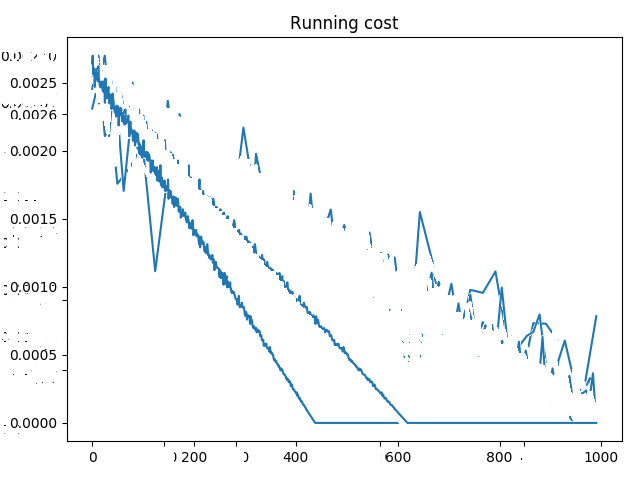

In [13]:
## optimization plotting tool

cost_current_iteration = 0
cost_history = []
cost_iteration_number_history = []

f, (cost_axis) = plt.subplots(1, 1)

cost_axis.plot(cost_iteration_number_history, cost_history)
cost_axis.set_title('Running cost')

plt.tight_layout()

In [14]:
## optimize

num_iterations = 1000
num_samples_per_iteration = 10000
step_rate = 1e-2
slack_var = .00

# K has already been initialized above, and initial policy visualized

import time
print "first P is", P
print "first K is", K

for cost_iteration in range(num_iterations):
    
    start = time.time()
    
    cost = 0
    
    samples = 0.2*(torch.rand(2,num_samples_per_iteration).type(dtype)*2 - torch.ones(2,num_samples_per_iteration))
    many_x_i = Variable(samples, requires_grad=True)
    Vdot = compute_Vdot_vectorized(many_x_i)
    cost = Vdot.clamp(min=-slack_var).sum()
        
    ## Automatically differentiate
    cost.backward()

    # Update K via gradient descent
    K.data -= step_rate * K.grad.data
    #P.data -= step_rate * P.grad.data
    
    # Project P into feasible
    #P.data = torch.abs(P.data)
    # Make P numerically stable by normalizing
    #P.data = P.data/(P.data.pow(2).sum())
      
    # Manually zero the gradients after running the backward pass
    K.grad.data.zero_()
    #P.grad.data.zero_()
    
    print time.time() - start, "is time for one step of grad descent"
    print 
    print cost.data[0]
    
    # handle plotting
    cost_history.append(cost.data[0])
    cost_iteration_number_history.append(cost_iteration)
    
    if cost_iteration % 10 == 0:
        cost_axis.lines[0].set_xdata(cost_iteration_number_history)
        cost_axis.lines[0].set_ydata(cost_history)
        cost_axis.relim()
        cost_axis.autoscale_view()
        cost_axis.figure.canvas.draw()
        
    if cost.data[0] == 0:
        break
        
    print "P is", P
    print "K is", K
    
    if cost_iteration == num_iterations - 1:
        print "didn't converge"

first P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

first K is Variable containing:
-0.1066
-0.7385
[torch.FloatTensor of size 2]

0.00927686691284 is time for one step of grad descent

0.00264318846166
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.1064
-0.7385
[torch.FloatTensor of size 2]

0.00397300720215 is time for one step of grad descent

0.00269968016073
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.1061
-0.7385
[torch.FloatTensor of size 2]

0.00459694862366 is time for one step of grad descent

0.00256282952614
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.1059
-0.7385
[torch.FloatTensor of size 2]

0.00426697731018 is time for one step of grad descent

0.002580414759
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.1056
-0.7385
[to

0.00413703918457 is time for one step of grad descent

0.002363512991
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0961
-0.7385
[torch.FloatTensor of size 2]

0.00323700904846 is time for one step of grad descent

0.00230770022608
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0959
-0.7385
[torch.FloatTensor of size 2]

0.00342297554016 is time for one step of grad descent

0.00229388917796
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0957
-0.7385
[torch.FloatTensor of size 2]

0.00248908996582 is time for one step of grad descent

0.00228033238091
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0954
-0.7385
[torch.FloatTensor of size 2]

0.00286102294922 is time for one step of grad descent

0.00232177949511
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTens

P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0844
-0.7385
[torch.FloatTensor of size 2]

0.00223588943481 is time for one step of grad descent

0.00204863073304
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0842
-0.7385
[torch.FloatTensor of size 2]

0.00193214416504 is time for one step of grad descent

0.00205769715831
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0839
-0.7385
[torch.FloatTensor of size 2]

0.00188803672791 is time for one step of grad descent

0.00197895453312
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0837
-0.7385
[torch.FloatTensor of size 2]

0.00194787979126 is time for one step of grad descent

0.00204724585637
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0834
-0.7385
[torch.FloatT

0.00334787368774 is time for one step of grad descent

0.00164576352108
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0681
-0.7385
[torch.FloatTensor of size 2]

0.00268507003784 is time for one step of grad descent

0.00161030539311
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0679
-0.7385
[torch.FloatTensor of size 2]

0.002681016922 is time for one step of grad descent

0.00163591315504
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0677
-0.7385
[torch.FloatTensor of size 2]

0.00277209281921 is time for one step of grad descent

0.00166429381352
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0674
-0.7385
[torch.FloatTensor of size 2]

0.00362586975098 is time for one step of grad descent

0.00158734654542
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTens

K is Variable containing:
-0.0552
-0.7385
[torch.FloatTensor of size 2]

0.00240516662598 is time for one step of grad descent

0.00137054268271
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0550
-0.7385
[torch.FloatTensor of size 2]

0.00210309028625 is time for one step of grad descent

0.00129071308766
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0547
-0.7385
[torch.FloatTensor of size 2]

0.0021378993988 is time for one step of grad descent

0.00132170692086
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0545
-0.7385
[torch.FloatTensor of size 2]

0.00208687782288 is time for one step of grad descent

0.00136913510505
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0543
-0.7385
[torch.FloatTensor of size 2]

0.0021698474884 is time for one step of grad descent

0.

P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0406
-0.7385
[torch.FloatTensor of size 2]

0.00319910049438 is time for one step of grad descent

0.00103322649375
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0403
-0.7385
[torch.FloatTensor of size 2]

0.00307106971741 is time for one step of grad descent

0.000979718519375
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0401
-0.7385
[torch.FloatTensor of size 2]

0.00326108932495 is time for one step of grad descent

0.000980399781838
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0398
-0.7385
[torch.FloatTensor of size 2]

0.00240182876587 is time for one step of grad descent

0.00095547363162
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0396
-0.7385
[torch.Floa

P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0235
-0.7385
[torch.FloatTensor of size 2]

0.00186014175415 is time for one step of grad descent

0.000574612640776
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0233
-0.7385
[torch.FloatTensor of size 2]

0.00167298316956 is time for one step of grad descent

0.000583056360483
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0230
-0.7385
[torch.FloatTensor of size 2]

0.00167107582092 is time for one step of grad descent

0.000552823941689
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0228
-0.7385
[torch.FloatTensor of size 2]

0.00167798995972 is time for one step of grad descent

0.000549612741452
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0226
-0.7385
[torch.Fl

P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0138
-0.7385
[torch.FloatTensor of size 2]

0.00198101997375 is time for one step of grad descent

0.000327051675413
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0135
-0.7385
[torch.FloatTensor of size 2]

0.00181889533997 is time for one step of grad descent

0.000331964401994
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0133
-0.7385
[torch.FloatTensor of size 2]

0.0018048286438 is time for one step of grad descent

0.000314005446853
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0131
-0.7385
[torch.FloatTensor of size 2]

0.0017728805542 is time for one step of grad descent

0.000319325510645
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0128
-0.7385
[torch.Floa

0.00491809844971 is time for one step of grad descent

0.000116536255518
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0045
-0.7385
[torch.FloatTensor of size 2]

0.00272393226624 is time for one step of grad descent

0.00011355355673
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0043
-0.7385
[torch.FloatTensor of size 2]

0.00235104560852 is time for one step of grad descent

0.000100137396657
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0040
-0.7385
[torch.FloatTensor of size 2]

0.00236010551453 is time for one step of grad descent

9.87646053545e-05
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0038
-0.7385
[torch.FloatTensor of size 2]

0.00214886665344 is time for one step of grad descent

9.22027466004e-05
P is Variable containing:
 0.8199
 0.1021
[torch.Flo

0.00353288650513 is time for one step of grad descent

5.01217331528e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.00270700454712 is time for one step of grad descent

6.48743558873e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.00325393676758 is time for one step of grad descent

5.06311381709e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.00312685966492 is time for one step of grad descent

6.01526328747e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.00330495834351 is time for one step of grad descent

5.1334991813e-11
P is Variable containing:
 0.8199
 0.1021
[torch.Flo

P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.00318908691406 is time for one step of grad descent

7.02688185417e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.00308895111084 is time for one step of grad descent

5.6787585051e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.00298309326172 is time for one step of grad descent

6.9014585713e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.00266480445862 is time for one step of grad descent

5.56243939798e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.Floa

P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.00192379951477 is time for one step of grad descent

6.11748152135e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.00176405906677 is time for one step of grad descent

5.66746094499e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.00172710418701 is time for one step of grad descent

6.57652890479e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.00174307823181 is time for one step of grad descent

5.56319434963e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.Fl

P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.00192999839783 is time for one step of grad descent

6.04837013807e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.001788854599 is time for one step of grad descent

4.82790474265e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.00176906585693 is time for one step of grad descent

6.21215370811e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.00176095962524 is time for one step of grad descent

5.94773813534e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.Floa

P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.0020968914032 is time for one step of grad descent

5.75981484729e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.00179004669189 is time for one step of grad descent

6.26804302906e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.00180292129517 is time for one step of grad descent

7.38336822237e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.00176501274109 is time for one step of grad descent

5.90201845729e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.Flo

0.0025680065155 is time for one step of grad descent

7.88161202969e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.00309705734253 is time for one step of grad descent

5.71885663825e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.0028669834137 is time for one step of grad descent

7.18640702502e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.00322604179382 is time for one step of grad descent

6.54034604253e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.00295901298523 is time for one step of grad descent

5.00228747313e-11
P is Variable containing:
 0.8199
 0.1021
[torch.Floa

P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.00266599655151 is time for one step of grad descent

5.75528028013e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.00250482559204 is time for one step of grad descent

5.03152831899e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.00254678726196 is time for one step of grad descent

4.50605976143e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.00292086601257 is time for one step of grad descent

6.88643864155e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.Fl

P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.00306105613708 is time for one step of grad descent

6.95270646611e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.00289988517761 is time for one step of grad descent

5.11379306956e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.00295305252075 is time for one step of grad descent

5.40577582697e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.00304412841797 is time for one step of grad descent

6.41092595677e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.Fl

P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.00314497947693 is time for one step of grad descent

5.10916517427e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.00298094749451 is time for one step of grad descent

6.85597828509e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.00356912612915 is time for one step of grad descent

7.07181396775e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

0.00321221351624 is time for one step of grad descent

6.6982808189e-11
P is Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
-0.7385
[torch.Flo

In [15]:
print K
print P

Variable containing:
 0.0001
-0.7385
[torch.FloatTensor of size 2]

Variable containing:
 0.8199
 0.1021
[torch.FloatTensor of size 2]



## Analytical pendulum controller... need to think about

$$x = 
       \begin{bmatrix} x_1 \\ x_2
        \end{bmatrix} $$

$$\dot{x} = f(x,u) =
       \begin{bmatrix} x_2 \\ u
        \end{bmatrix} $$
        
Policy

$$ u = \pi_K(x) = -K^Tx = - k_1x_1 - k_2x_2$$
        
Lyapunov

$$V(x) = P^Tx = p_1x_1^2 + p_2x_2^2 = \text{p.s.d. by construction}$$

$$\dot{V}(x) = \bigg[ \frac{\partial V}{\partial x}\bigg]^T \big[f(x,\pi_K(x) \big] $$

$$ = \begin{bmatrix} 2p_1x_1 \\ 2p_2x_2
        \end{bmatrix}^T \begin{bmatrix} x_2 \\ -k_1x_1 - k_2x_2
        \end{bmatrix} $$
        
$$ =  2p_1x_1x_2 + 2p_2x_2( - k_1x_1 - k_2x_2) $$

$$ =  2p_1x_1x_2 - 2p_2k_1x_1x_2 - 2p_2k_2x_2^2 $$

We need both terms to be negative semidefinite:

$$ =  2x_1x_2(p_1 - p_2k_1 ) - 2p_2k_2x_2^2 $$

Therefore conditions are:

a) $p_1 = p_2k_1$

b) $k_2 > 0$ ($p_2$ already must be $> 0$) 

In [16]:
for i in range(10000):
    x_i = Variable(torch.randn(2).type(dtype), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 1e-2:
        print "false, counterexample found: ", x_i
        print i
        print Vdot.data[0]
        break

In [15]:
# Note: first time I ended up with these values:

# print K
# print P
# Variable containing:
#   0.2410
#  16.2734
# [torch.FloatTensor of size 2]

# Variable containing:
#  0.3484
#  0.8831
# [torch.FloatTensor of size 2]

#Which gave only:

# # condition (a):  p_1 - p_2*k_1
# print P[0] - P[1]*K[0]

# # condition (b): k_2 > 0
# print K[1]

# Variable containing:
#  0.1356
# [torch.FloatTensor of size 1]

# Variable containing:
#  16.2734
# [torch.FloatTensor of size 1]

# But this was Vdot negative semidefinite over all samples, since k_2 was so large it could outweigh the first term